# **House Prices Regression Preprocessing**

This is the house pricing regression of kaggler competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In this notebook, we will carry out preprocessing of the data sets.

In [537]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helper_preprocessing as hp
import importlib

importlib.reload(hp)

<module 'helper_preprocessing' from '/content/helper_preprocessing.py'>

## **Exploratory Data Analysis**

We have two datasets. The first one is the training dataset, which we will use to train and validate our model. The second one is the test dataset, which is used for the official Kaggle competition. Note that the test dataset does not contain the `SalePrice` column.

In [538]:
# Load the data sets
path_test = "test_raw.csv"
path_train = "train_raw.csv"

df_test = pd.read_csv(path_test)
df_train = pd.read_csv(path_train)

#Number of data in test df
n_test = df_test.shape[0]

# Save target y_train
y_train = df_train['SalePrice'].copy()

# Delete SalePrice
df_train.drop('SalePrice', axis=1, inplace=True)

# Concat in orderd test, train
df_concat = pd.concat([df_test, df_train], ignore_index=True)


In [539]:
# See the size of the dataFrames
print('Train shape:', df_train.shape)
print('Test shape:', df_test.shape)
print('Concat shape:', df_concat.shape)


Train shape: (1460, 80)
Test shape: (1459, 80)
Concat shape: (2919, 80)


In [540]:
# Check for the datatype columns and number of non-null values
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [541]:
df_concat.drop('Id', axis=1, inplace=True)

In [542]:

hp.missing_percentage(df_concat, 10)

                      0
PoolQC        99.657417
MiscFeature   96.402878
Alley         93.216855
Fence         80.438506
MasVnrType    60.500171
FireplaceQu   48.646797
LotFrontage   16.649538
GarageCond     5.447071
GarageFinish   5.447071
GarageYrBlt    5.447071


In [543]:

print("Negative values in train data set:", list(hp.check_negative_values(df_concat)))

Negative values in train data set: []


In [544]:
# check for duplicated rows
print("Duplicate values in train data set:", df_concat.duplicated().any())


Duplicate values in train data set: True


In [545]:
# Check for the categories in the categorical columns
cat_cols = df_concat.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
  print(f"{col}: {df_concat[col].unique()}")

MSZoning: ['RH' 'RL' 'RM' 'FV' 'C (all)' nan]
Street: ['Pave' 'Grvl']
Alley: [nan 'Pave' 'Grvl']
LotShape: ['Reg' 'IR1' 'IR2' 'IR3']
LandContour: ['Lvl' 'HLS' 'Bnk' 'Low']
Utilities: ['AllPub' nan 'NoSeWa']
LotConfig: ['Inside' 'Corner' 'FR2' 'CulDSac' 'FR3']
LandSlope: ['Gtl' 'Mod' 'Sev']
Neighborhood: ['NAmes' 'Gilbert' 'StoneBr' 'BrDale' 'NPkVill' 'NridgHt' 'Blmngtn'
 'NoRidge' 'Somerst' 'SawyerW' 'Sawyer' 'NWAmes' 'OldTown' 'BrkSide'
 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor' 'Blueste' 'IDOTRR'
 'Mitchel' 'Timber' 'MeadowV' 'Veenker']
Condition1: ['Feedr' 'Norm' 'PosN' 'RRNe' 'Artery' 'RRNn' 'PosA' 'RRAn' 'RRAe']
Condition2: ['Norm' 'Feedr' 'PosA' 'PosN' 'Artery' 'RRNn' 'RRAn' 'RRAe']
BldgType: ['1Fam' 'TwnhsE' 'Twnhs' 'Duplex' '2fmCon']
HouseStyle: ['1Story' '2Story' 'SLvl' '1.5Fin' 'SFoyer' '2.5Unf' '1.5Unf' '2.5Fin']
RoofStyle: ['Gable' 'Hip' 'Gambrel' 'Flat' 'Mansard' 'Shed']
RoofMatl: ['CompShg' 'Tar&Grv' 'WdShake' 'WdShngl' 'Metal' 'Membran' 'Roll'
 'ClyTile']
Exterior1

In [546]:
# Check for range in year columns
print("Range of year columns:")
print("YearBuilt:", df_concat['YearBuilt'].min(),'-', df_concat['YearBuilt'].max())
print("YearRemodAdd:", df_concat['YearRemodAdd'].min(), '-', df_concat['YearRemodAdd'].max())


Range of year columns:
YearBuilt: 1872 - 2010
YearRemodAdd: 1950 - 2010


**Conclusions:** The data has several missing values and typos in categorical data. In the next section we preprocess the data to adress these issues.

## **Cleaning the Data**

In the cleaning data section, we will:

* Clean the data and handle inconsistencies.
* Handle missing values.
* Look for unrealistic rows and drop them.

From the las section we found that the columns `PoolQ`, `CMiscFeature`, `Alley` and `Fence` are missing more than 80% values. We can drop these columns.

In [547]:
df_concat.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)

In [548]:
# To correct typos lets include a dictionary with the valid entries per feature, this values are extracted from the documentation
valid_values_dict = {
    'MSSubClass': [20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190],
    'MSZoning': ['A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM'],
    'Street': ['Grvl', 'Pave'],
    'Alley': ['Grvl', 'Pave', 'NA'],
    'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'],
    'LandContour': ['Lvl', 'Bnk', 'HLS', 'Low'],
    'Utilities': ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'],
    'LotConfig': ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'],
    'LandSlope': ['Gtl', 'Mod', 'Sev'],
    'Neighborhood': ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker'],
    'Condition1': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'],
    'Condition2': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'],
    'BldgType': ['1Fam', '2FmCon', 'Duplx', 'TwnhsE', 'TwnhsI'],
    'HouseStyle': ['1Story', '1.5Fin', '1.5Unf', '2Story', '2.5Fin', '2.5Unf', 'SFoyer', 'SLvl'],
    'RoofStyle': ['Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard', 'Shed'],
    'RoofMatl': ['ClyTile', 'CompShg', 'Membran', 'Metal', 'Roll', 'Tar&Grv', 'WdShake', 'WdShngl'],
    'Exterior1st': ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],
    'Exterior2nd': ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'BrkCmn', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],
    'MasVnrType': ['BrkCmn', 'BrkFace', 'CBlock', 'None', 'Stone'],
    'ExterQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'ExterCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'Foundation': ['BrkTil', 'CBlock', 'PConc', 'Slab', 'Stone', 'Wood'],
    'BsmtQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'BsmtCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'BsmtExposure': ['Gd', 'Av', 'Mn', 'No', 'NA'],
    'BsmtFinType1': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
    'BsmtFinType2': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
    'Heating': ['Floor', 'GasA', 'GasW', 'Grav', 'OthW', 'Wall'],
    'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'CentralAir': ['Y', 'N'],
    'Electrical': ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'],
    'KitchenQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'Functional': ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Salvage'],
    'FireplaceQu': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'GarageType': ['2Types', 'Attchd', 'Basment', 'BuiltIn', 'CarPort', 'Detchd', 'NA'],
    'GarageFinish': ['Fin', 'RFn', 'Unf', 'NA'],
    'GarageQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'GarageCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'PavedDrive': ['Y', 'P', 'N'],
    'PoolQC': ['Ex', 'Gd', 'TA', 'Fa', 'NA'],
    'Fence': ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA'],
    'MiscFeature': ['Elev', 'Gar2', 'Othr', 'Shed', 'TenC', 'NA'],
    'SaleType': ['WD', 'CWD', 'VWD', 'New', 'COD', 'Con', 'ConLw', 'ConLI', 'ConLD', 'Oth'],
    'SaleCondition': ['Normal', 'Abnorml', 'AdjLand', 'Alloca', 'Family', 'Partial']
}


In [549]:
# preproces the dataframes using our helper function preprocess. This function
hp.preprocess(df_concat, valid_values_dict, threshole=0.9)

We found that MSZoning has the input `'C (all)'`, but the valid value is `'C'`, lets fix this issue.

In [550]:
df_concat['MSZoning'] = df_concat['MSZoning'].replace('C (all)', 'C')
df_concat['MSZoning'].unique()

array(['RH', 'RL', 'RM', 'FV', 'A'], dtype=object)

In [551]:
# Check for missing values after processing
print('Missing values percentage in train df')
hp.missing_percentage(df_concat)

Missing values percentage in train df
               0
MSSubClass   0.0
MSZoning     0.0
LotFrontage  0.0
LotArea      0.0
Street       0.0


In [552]:

# Check for the categories in the categorical columns after processing

cat_cols = df_concat.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
  print(f"{col}: {df_concat[col].unique()}")

MSZoning: ['RH' 'RL' 'RM' 'FV' 'A']
Street: ['Pave' 'Grvl']
LotShape: ['Reg' 'IR1' 'IR2' 'IR3']
LandContour: ['Lvl' 'HLS' 'Bnk' 'Low']
Utilities: ['AllPub' 'NoSeWa']
LotConfig: ['Inside' 'Corner' 'FR2' 'CulDSac' 'FR3']
LandSlope: ['Gtl' 'Mod' 'Sev']
Neighborhood: ['Names' 'Gilbert' 'StoneBr' 'BrDale' 'NPkVill' 'NridgHt' 'Blmngtn'
 'NoRidge' 'Somerst' 'SawyerW' 'Sawyer' 'NWAmes' 'OldTown' 'BrkSide'
 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor' 'Blueste' 'IDOTRR'
 'Mitchel' 'Timber' 'MeadowV' 'Veenker']
Condition1: ['Feedr' 'Norm' 'PosN' 'RRNe' 'Artery' 'RRNn' 'PosA' 'RRAn' 'RRAe']
Condition2: ['Norm' 'Feedr' 'PosA' 'PosN' 'Artery' 'RRNn' 'RRAn' 'RRAe']
BldgType: ['1Fam' 'TwnhsE' 'Duplx' '2FmCon']
HouseStyle: ['1Story' '2Story' 'SLvl' '1.5Fin' 'SFoyer' '2.5Unf' '1.5Unf' '2.5Fin']
RoofStyle: ['Gable' 'Hip' 'Gambrel' 'Flat' 'Mansard' 'Shed']
RoofMatl: ['CompShg' 'Tar&Grv' 'WdShake' 'WdShngl' 'Metal' 'Membran' 'Roll'
 'ClyTile']
Exterior1st: ['VinylSd' 'Wd Sdng' 'HdBoard' 'Plywood' 'Meta

## Checking Outliers

Lets plot boxplots to visualize if there are extreme otliers that can bias our model in the train data.


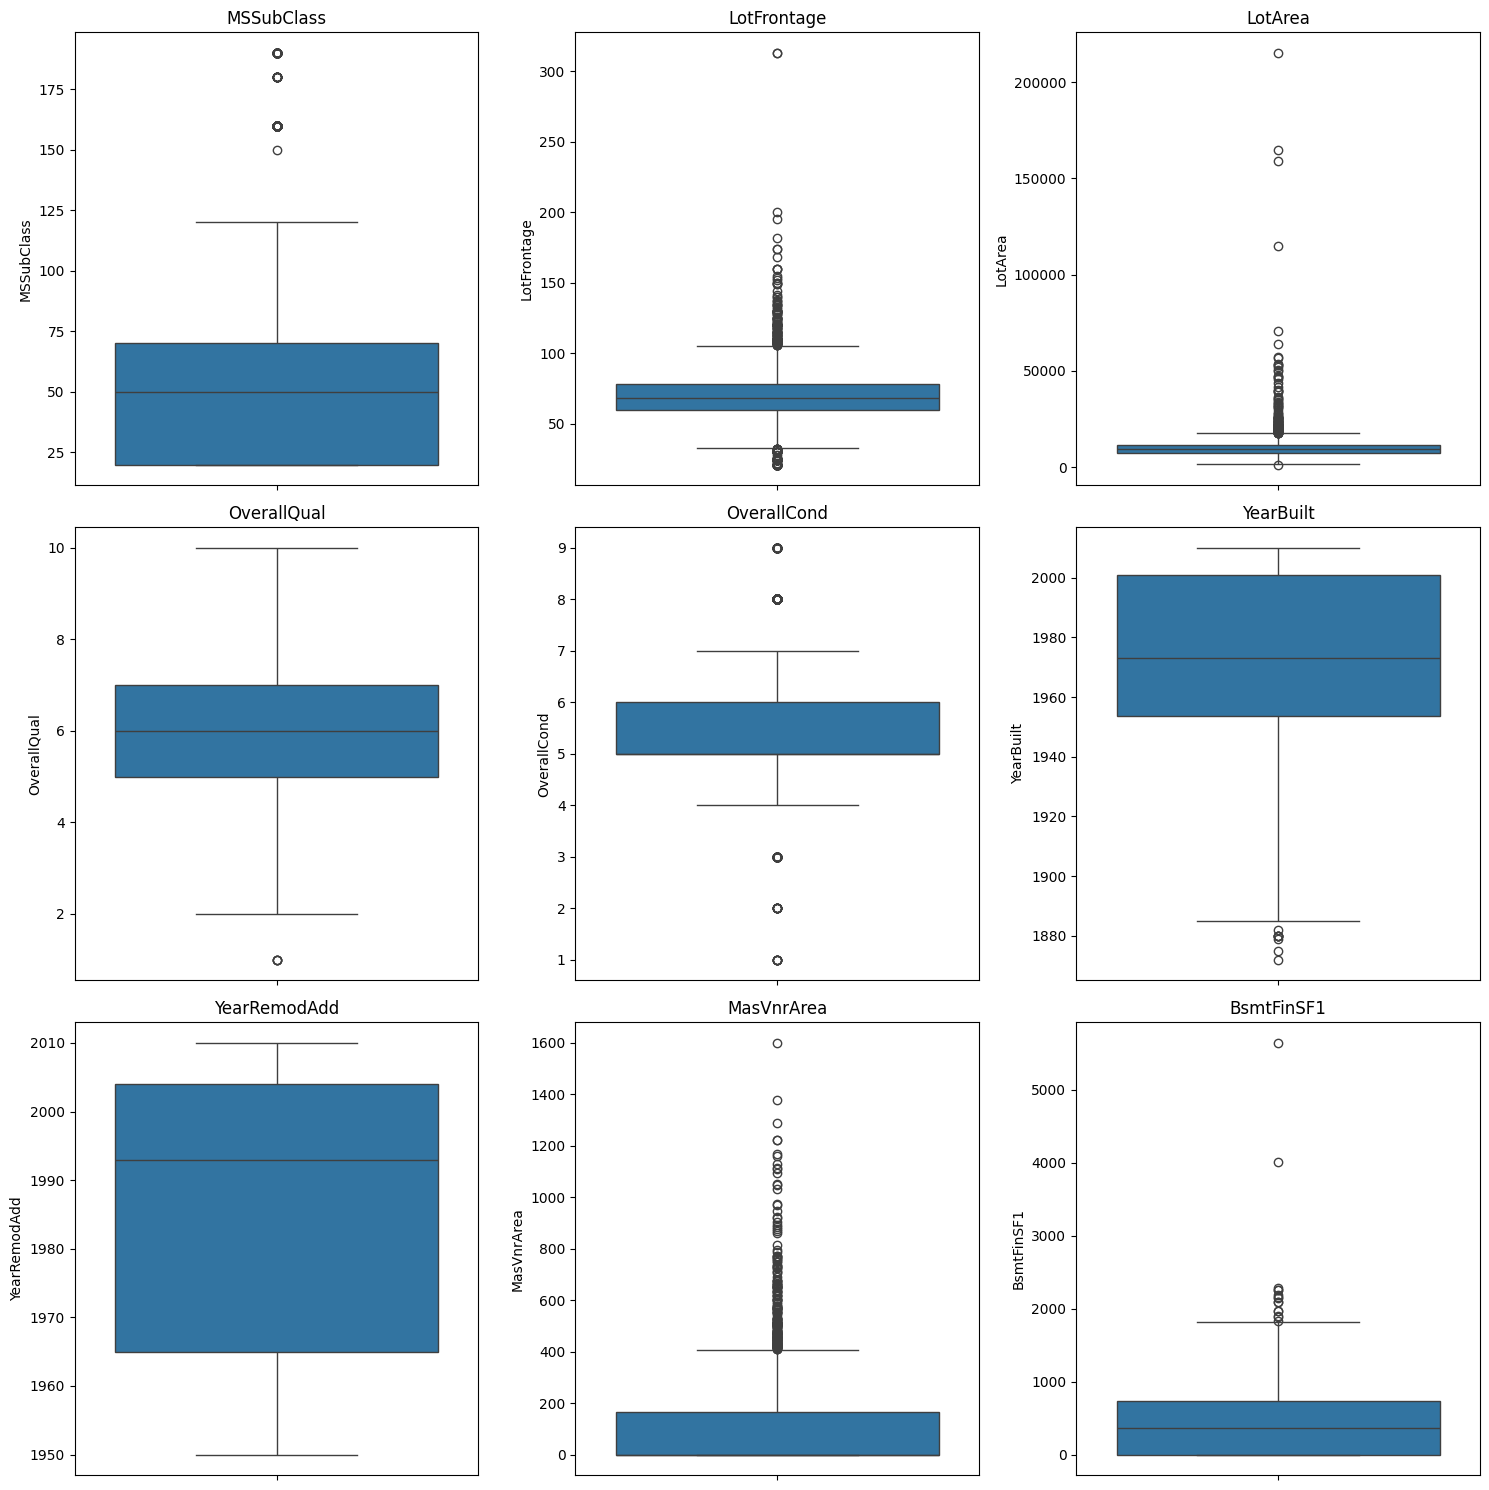

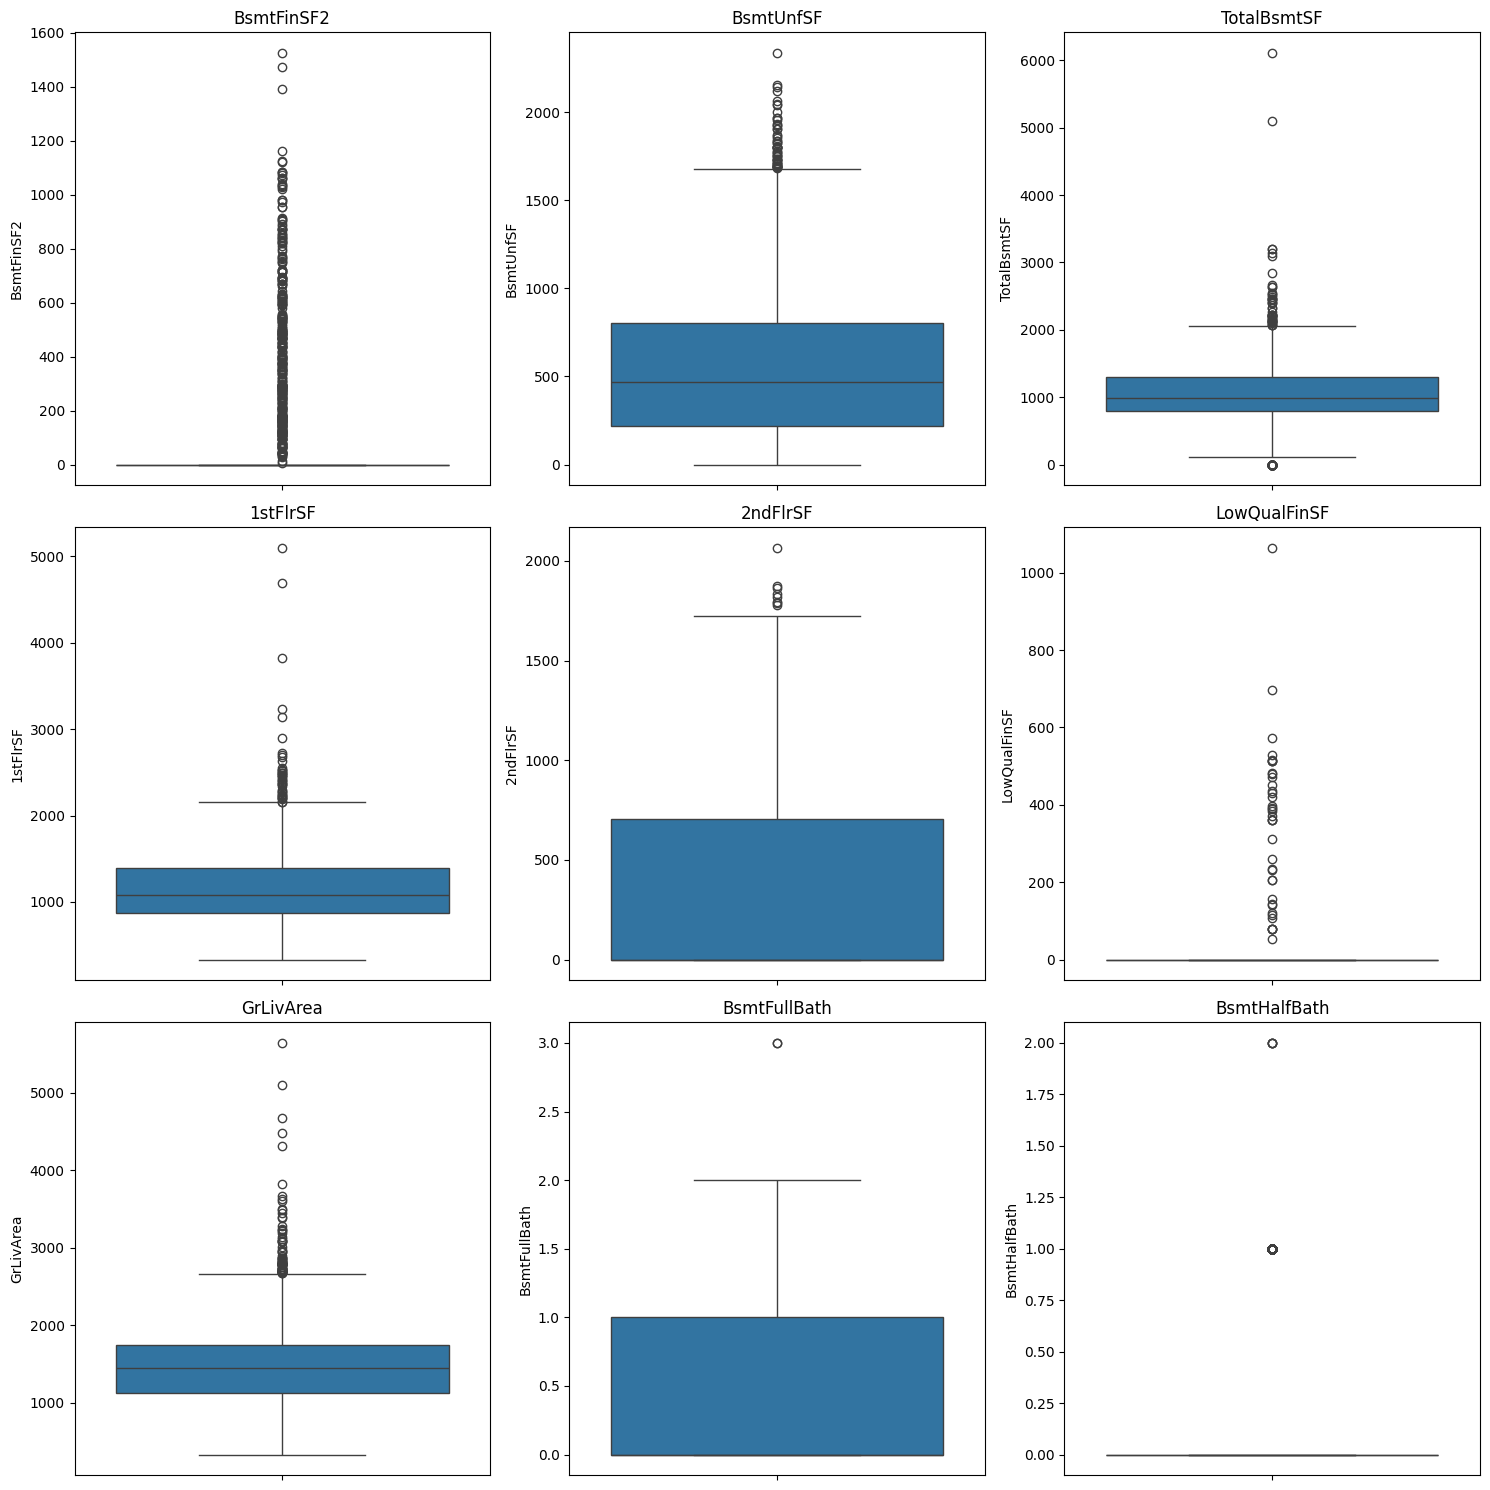

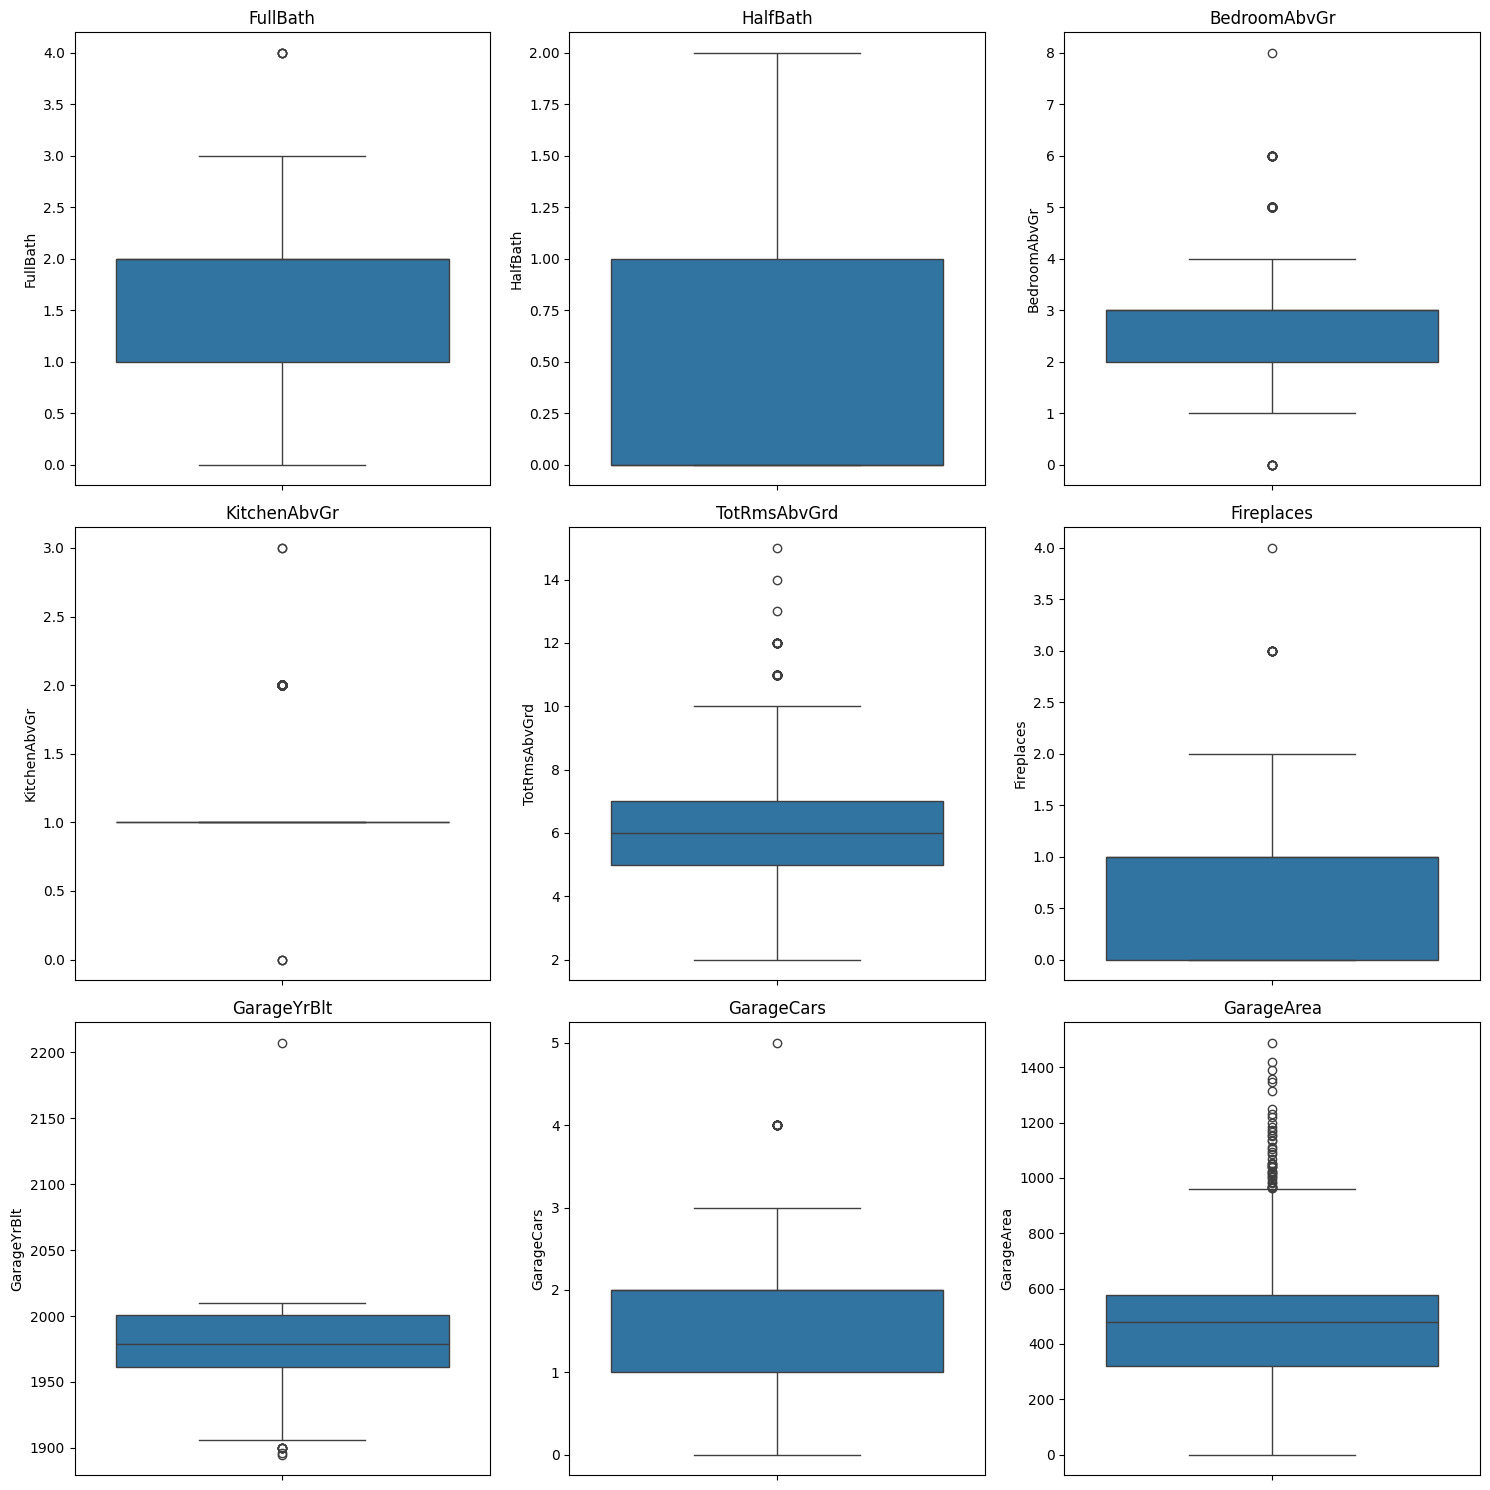

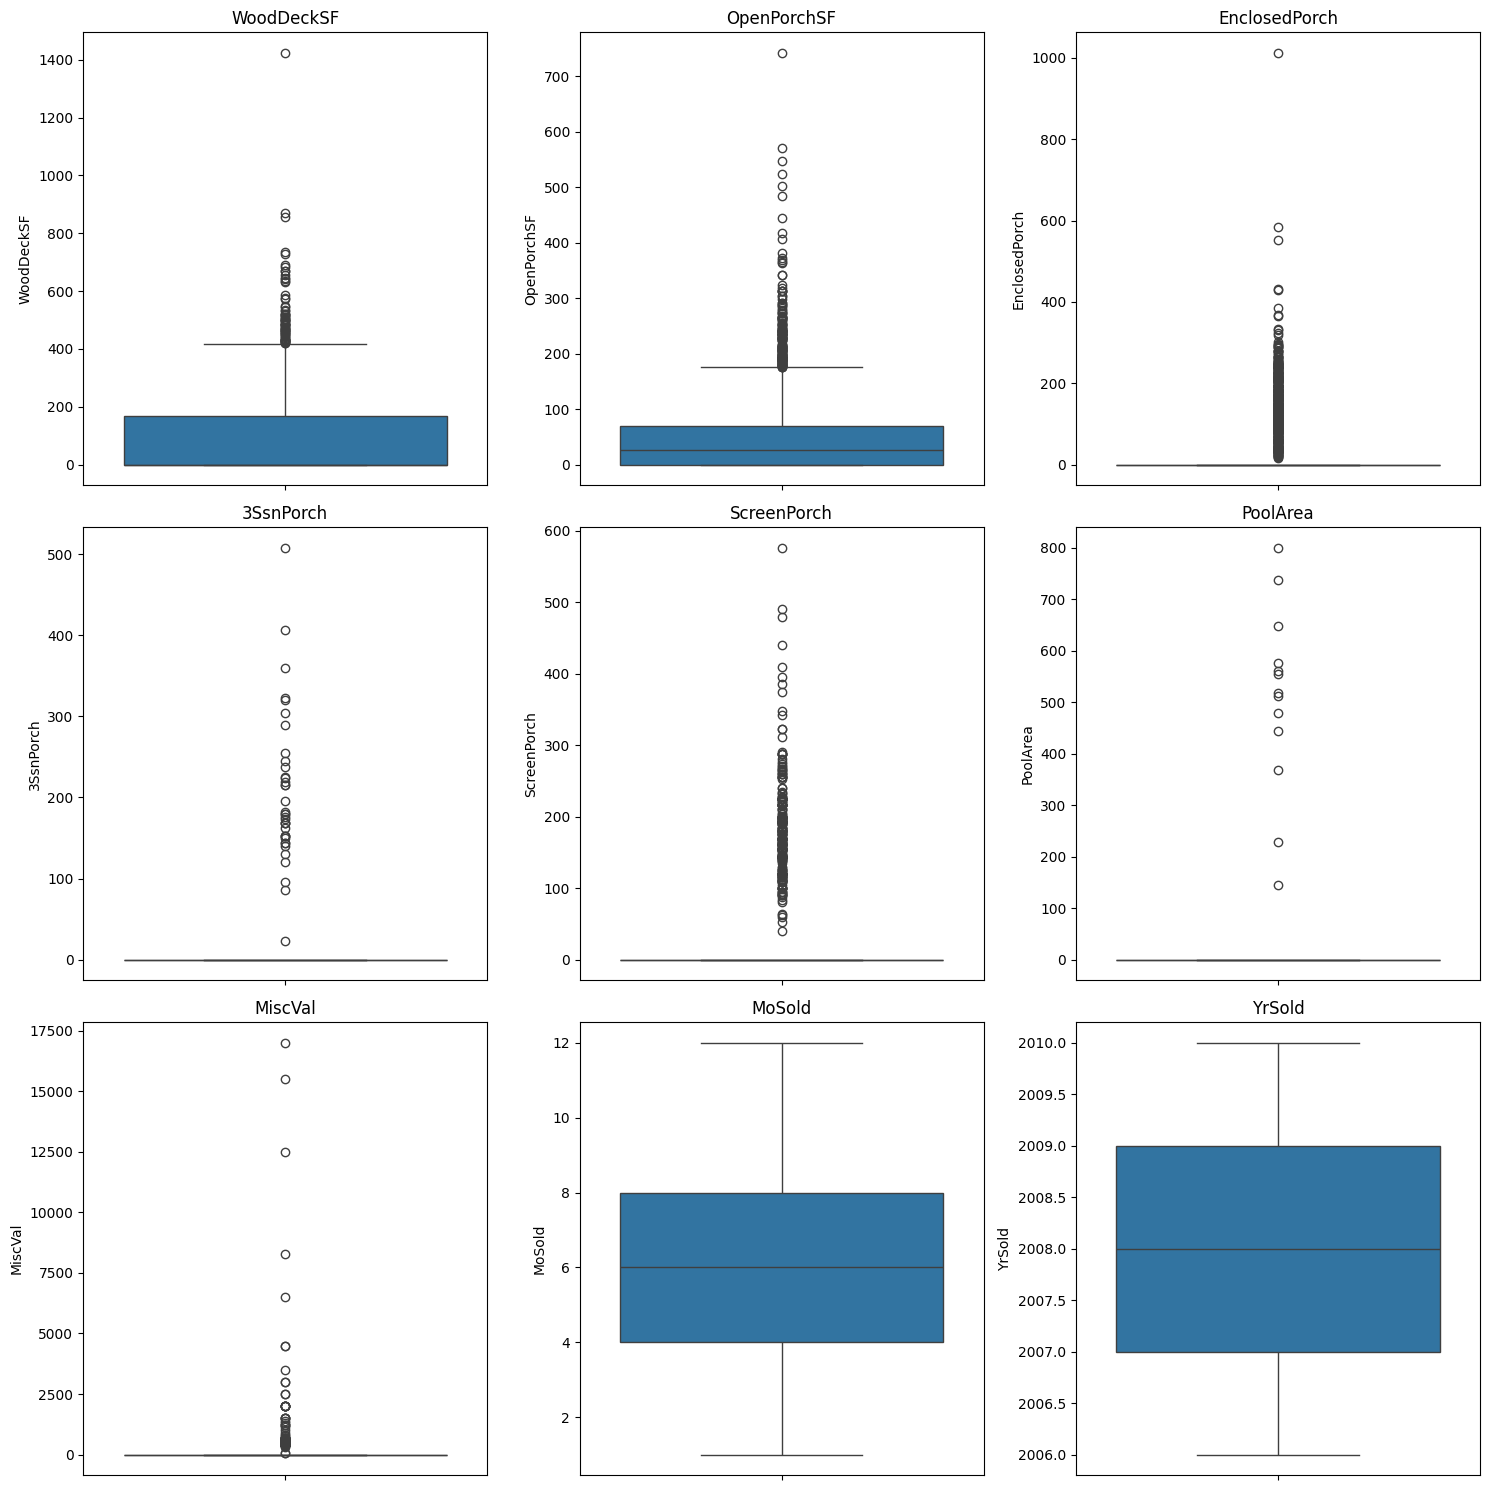

In [553]:
hp.plot_boxplots(df_concat)

In the next notebooks, we will use the data to train and evaluate the performance of several models. Some models are more sensitive to outliers, so we will handle them appropriately, applying a logarithmic transformation where needed for each model. However we need to check if there is any unrealistic entry in our data set. Let's look for outliers in the training set by plotting the scatter of the features vs the `Saleprice` column.

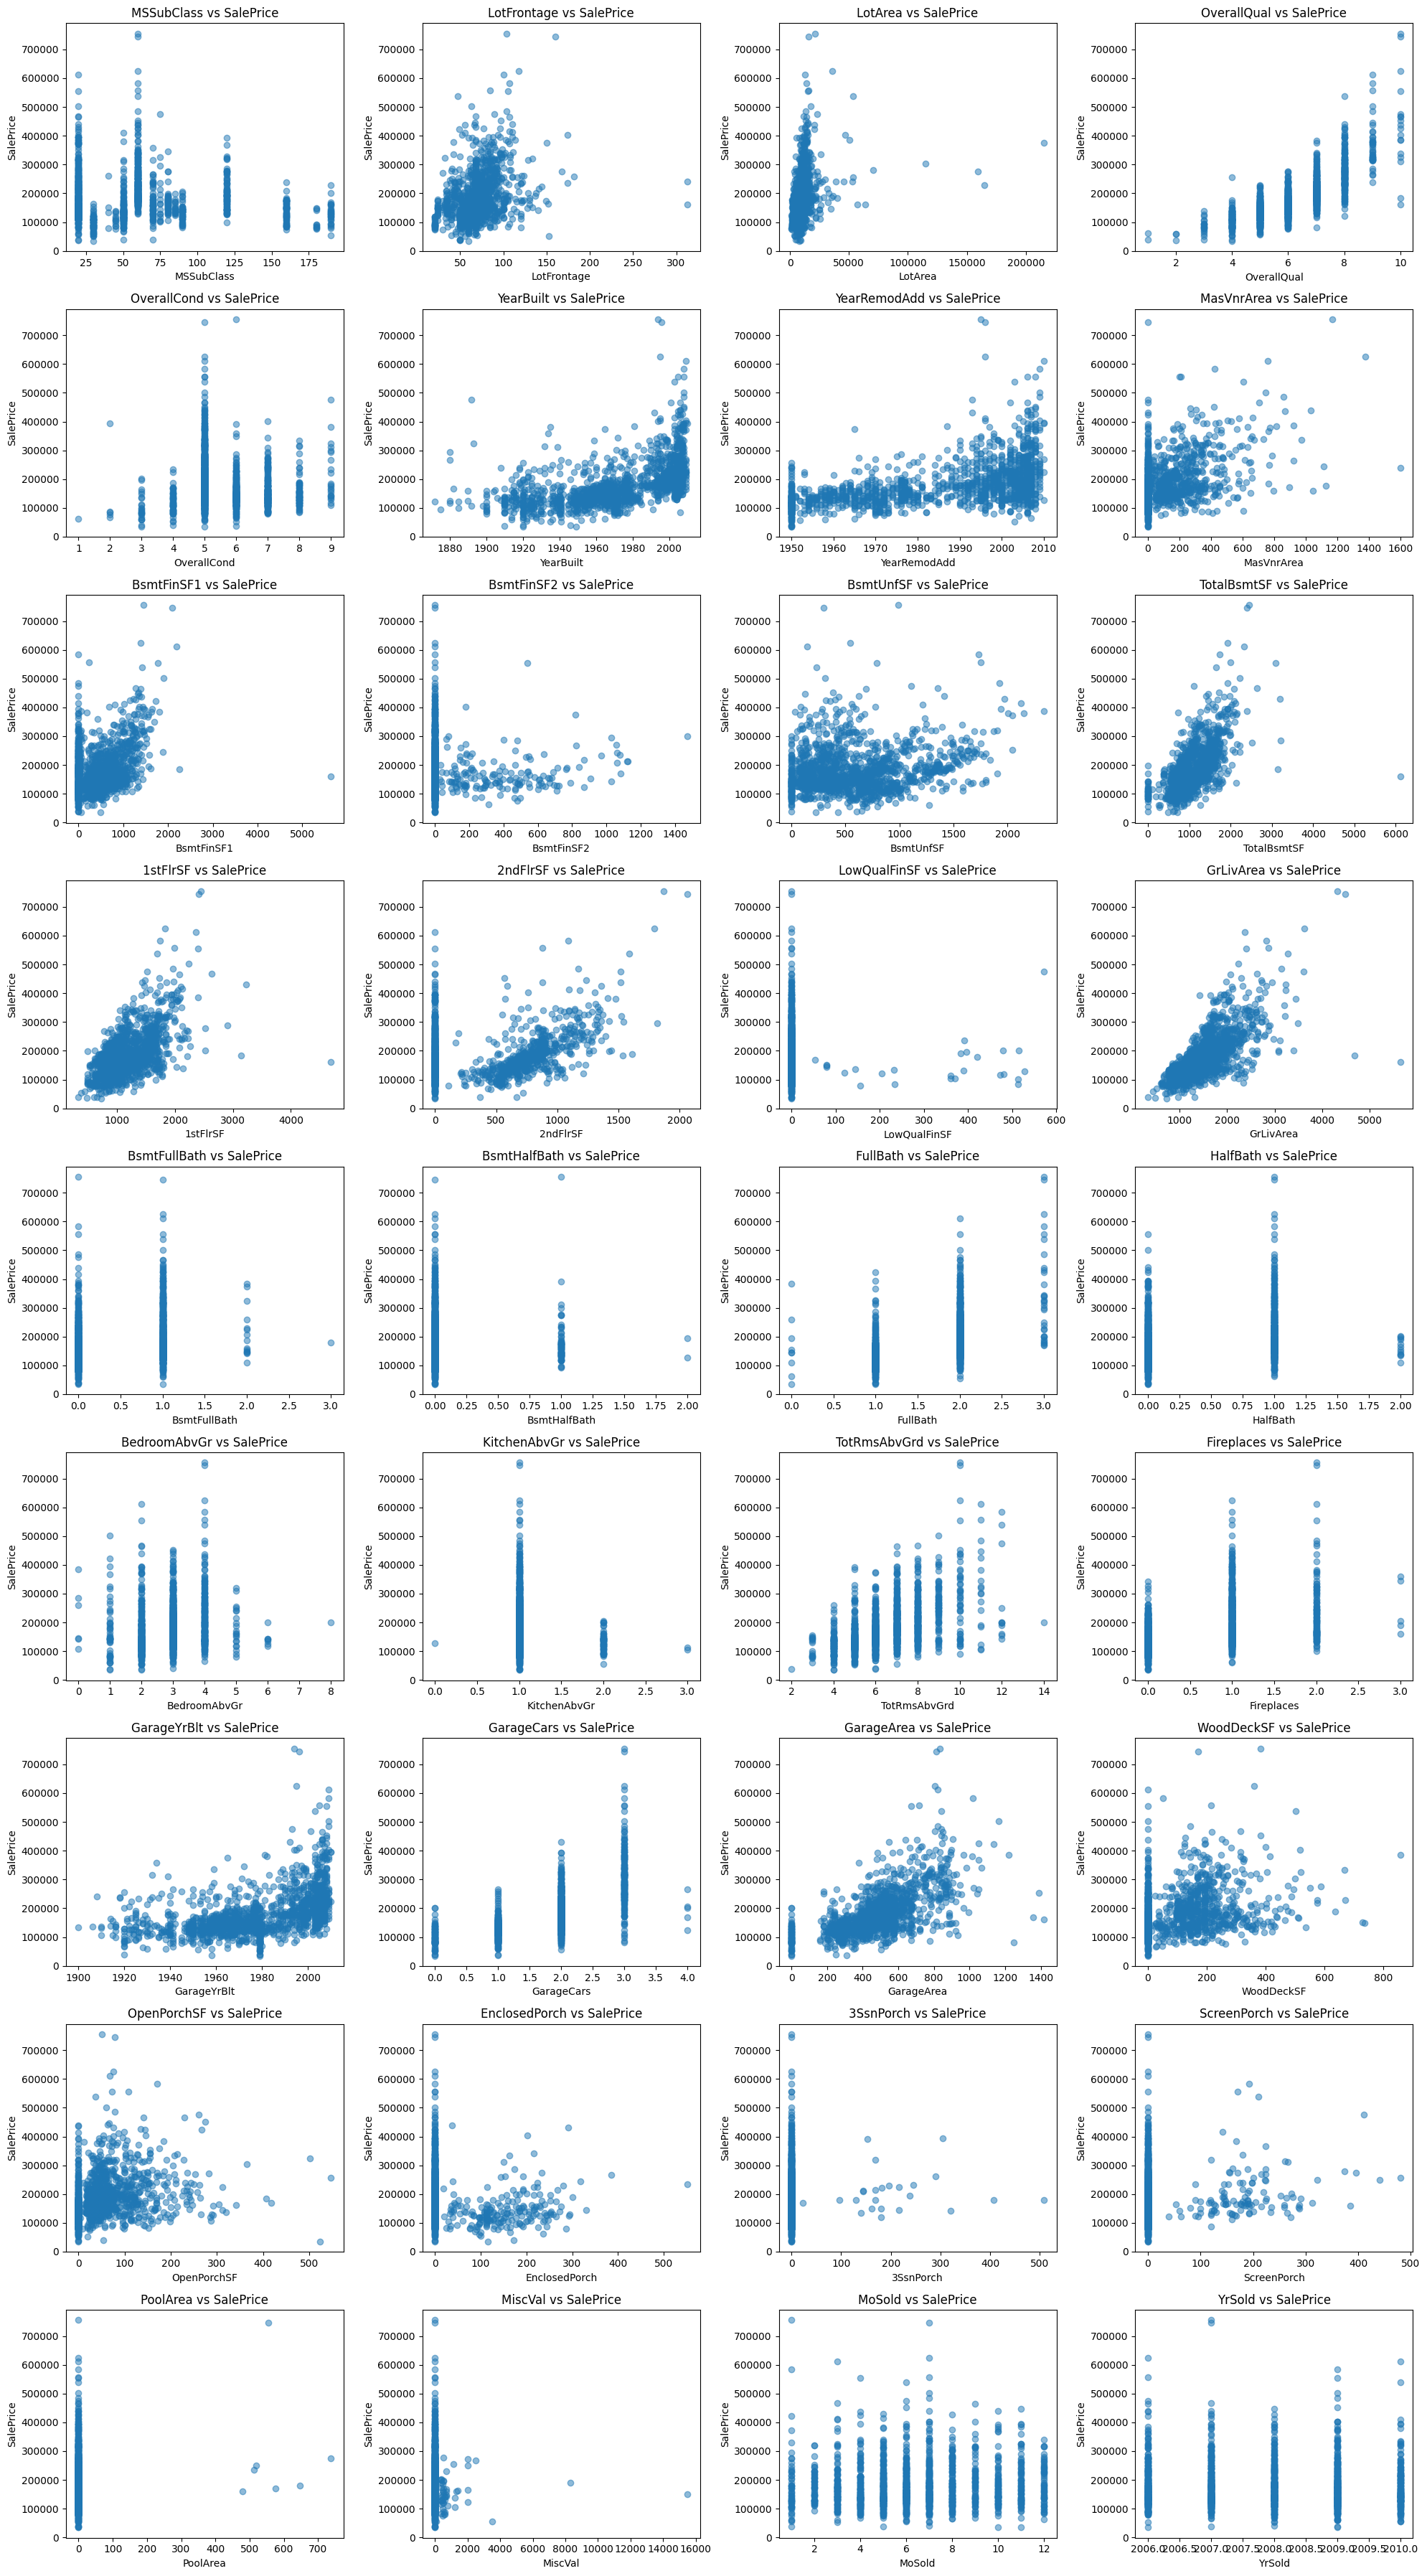

In [554]:
hp.plot_target_scatters(df_concat.iloc[n_test : , :], y_train)

In the scatter plot of `GrLivArea` vs `SalePrice` we see two entries with very high `GrLivArea` and low `SalePrice`. We consider this as an unrealistic entry and we drop them. We also drop apply some filters that cannot happen in a real scenario.

In [555]:

# STEP 1: Split train and test

df_train = df_concat.iloc[n_test:, :].reset_index(drop=True)  # train slice
df_test = df_concat.iloc[:n_test, :].reset_index(drop=True)   # test slice
y_train = y_train.reset_index(drop=True)                      # align indices

# STEP 2: Define outlier conditions

# Condition 1: Large area but low price
mask_large_low_price = ((df_train['GrLivArea'] > 4000) & (y_train < 300000)) | \
                       ((df_train['1stFlrSF'] > 4000) & (y_train < 200000))

# Condition 2: Unrealistic total area less than first floor or basement
mask_unrealistic_size = (df_train['GrLivArea'] < df_train['1stFlrSF']) | \
                        (df_train['GrLivArea'] < df_train['TotalBsmtSF'])

# Combine all conditions
mask_outliers = mask_large_low_price | mask_unrealistic_size

# STEP 3: Filter train data

df_train_clean = df_train.copy()[~mask_outliers]
y_train_clean = y_train.copy()[~mask_outliers]

# STEP 4: Concatenate train + test

df_concat_clean = pd.concat([df_test, df_train_clean], ignore_index=True)

#
# STEP 5: Show final shapes
#
print("Shapes after filtering and concatenation:")
print(f"Full dataset: {df_concat_clean.shape}")
print(f"Full dataset befor : {df_concat.shape}")
print(f"Train dataset clean: {df_train_clean.shape}")
print(f"y_train_clean: {y_train_clean.shape}")
print(f"Test dataset (unchanged): {df_test.shape}")
print(f"Number of outliers removed: {mask_outliers.sum()}")


Shapes after filtering and concatenation:
Full dataset: (2899, 75)
Full dataset befor : (2919, 75)
Train dataset clean: (1440, 75)
y_train_clean: (1440,)
Test dataset (unchanged): (1459, 75)
Number of outliers removed: 20


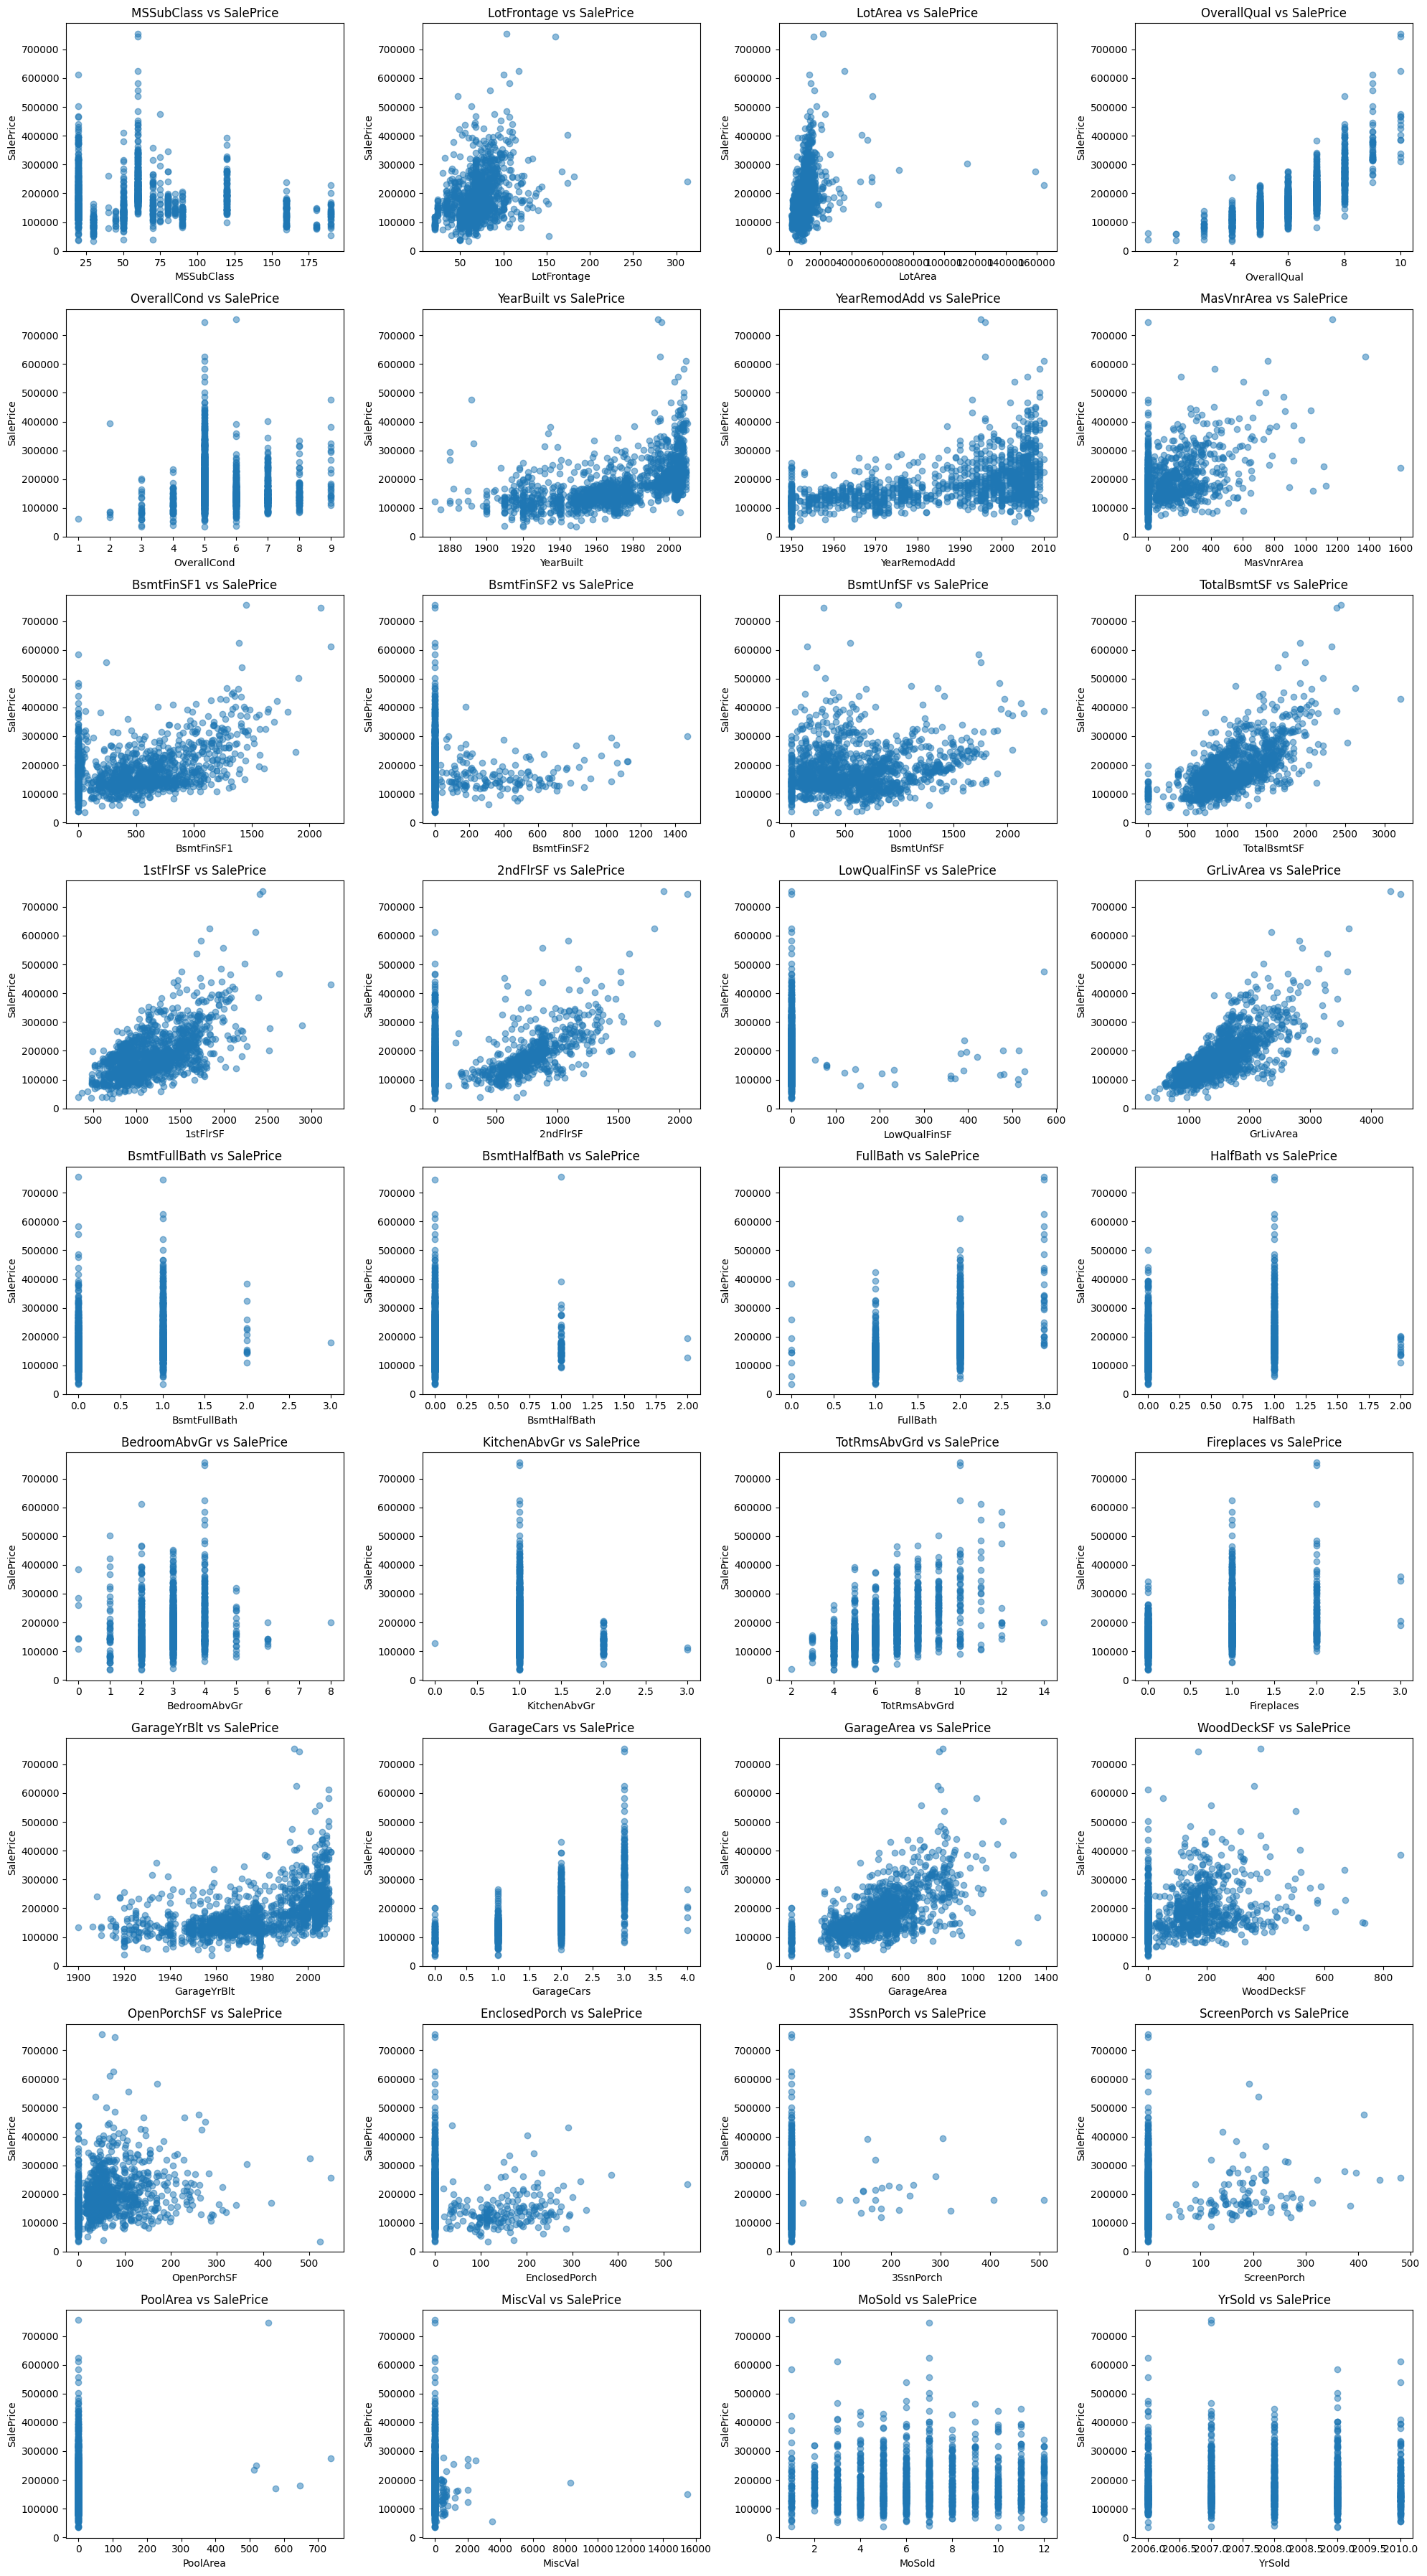

In [556]:
# Plot scatter after dropping
hp.plot_target_scatters(df_concat_clean .iloc[len(df_test) : , :], y_train_clean)

## Rare features
Finally, we will look for exceptional categories in the categorical features.

In [557]:
hp.count_categories(df_concat_clean)


Column: MSZoning
MSZoning
RL    2250
RM     460
FV     139
RH      25
A       25
Name: count, dtype: int64

Column: Street
Street
Pave    2887
Grvl      12
Name: count, dtype: int64

Column: LotShape
LotShape
Reg    1849
IR1     960
IR2      76
IR3      14
Name: count, dtype: int64

Column: LandContour
LandContour
Lvl    2609
HLS     119
Bnk     114
Low      57
Name: count, dtype: int64

Column: Utilities
Utilities
AllPub    2898
NoSeWa       1
Name: count, dtype: int64

Column: LotConfig
LotConfig
Inside     2118
Corner      508
CulDSac     174
FR2          85
FR3          14
Name: count, dtype: int64

Column: LandSlope
LandSlope
Gtl    2762
Mod     123
Sev      14
Name: count, dtype: int64

Column: Neighborhood
Neighborhood
Names      441
CollgCr    266
OldTown    239
Edwards    191
Somerst    181
Gilbert    165
NridgHt    164
Sawyer     151
NWAmes     129
SawyerW    124
Mitchel    112
BrkSide    108
Crawfor    103
IDOTRR      93
NoRidge     71
Timber      70
StoneBr     51
SWISU   

We see that there are many categories with rare occurrences, so we group these by creating a new category called 'Other'. We use a threshold of 4%.

In [558]:
hp.group_rare_categories(df_concat_clean,  min_freq=0.04)

In [559]:
hp.count_categories(df_concat_clean)


Column: MSZoning
MSZoning
RL       2250
RM        460
FV        139
Other      50
Name: count, dtype: int64

Column: Street
Street
Pave     2887
Other      12
Name: count, dtype: int64

Column: LotShape
LotShape
Reg      1849
IR1       960
Other      90
Name: count, dtype: int64

Column: LandContour
LandContour
Lvl      2609
Other     171
HLS       119
Name: count, dtype: int64

Column: Utilities
Utilities
AllPub    2898
Other        1
Name: count, dtype: int64

Column: LotConfig
LotConfig
Inside     2118
Corner      508
CulDSac     174
Other        99
Name: count, dtype: int64

Column: LandSlope
LandSlope
Gtl      2762
Mod       123
Other      14
Name: count, dtype: int64

Column: Neighborhood
Neighborhood
Other      848
Names      441
CollgCr    266
OldTown    239
Edwards    191
Somerst    181
Gilbert    165
NridgHt    164
Sawyer     151
NWAmes     129
SawyerW    124
Name: count, dtype: int64

Column: Condition1
Condition1
Norm     2496
Other     242
Feedr     161
Name: count, dtype

Lets drop the columns `street` and `Utilities` that have big concentration of categories in one category.

In [560]:
df_concat_clean.drop(['Street', 'Utilities'], axis=1, inplace=True)

To end the preprocessing, let's merge the 'Other' category with the most common value in those categories where there are few 'Other' values. We use a threshole of 5% as a criterion to merge.

In [561]:
hp.merge_other_with_most_frequent(df_concat_clean)
hp.count_categories(df_concat_clean)


Column: MSZoning
MSZoning
RL    2300
RM     460
FV     139
Name: count, dtype: int64

Column: LotShape
LotShape
Reg    1939
IR1     960
Name: count, dtype: int64

Column: LandContour
LandContour
Lvl      2609
Other     171
HLS       119
Name: count, dtype: int64

Column: LotConfig
LotConfig
Inside     2217
Corner      508
CulDSac     174
Name: count, dtype: int64

Column: LandSlope
LandSlope
Gtl    2776
Mod     123
Name: count, dtype: int64

Column: Neighborhood
Neighborhood
Other      848
Names      441
CollgCr    266
OldTown    239
Edwards    191
Somerst    181
Gilbert    165
NridgHt    164
Sawyer     151
NWAmes     129
SawyerW    124
Name: count, dtype: int64

Column: Condition1
Condition1
Norm     2496
Other     242
Feedr     161
Name: count, dtype: int64

Column: Condition2
Condition2
Norm    2899
Name: count, dtype: int64

Column: BldgType
BldgType
1Fam      2407
TwnhsE     321
Other      171
Name: count, dtype: int64

Column: HouseStyle
HouseStyle
1Story    1587
2Story     870


In [562]:

# Slice the train data and reset indices
df_train_slice = df_concat_clean.iloc[n_test:, :].reset_index(drop=True)
y_train_slice = y_train_clean.reset_index(drop=True)

# Concatenate columns
df_train_pre = pd.concat([df_train_slice, y_train_slice], axis=1)

# Slice test data
df_test_pre = df_concat_clean.iloc[:n_test, :]


In [563]:
# Save the preprocess data set in .csv
df_train_pre.to_csv('train_pre.csv', index=False)
df_test_pre.to_csv('test_pre.csv',index=False)